In [20]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
import re

In [32]:
def get_results(res_path):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            model, features, trend, most = spec.split('_')
        except:
            print('skipping', fname)

        results_by_specs[(model, features, trend, most)].append(fname)
    
    # for each config, find and parse most recent result file
    results = {}
    for spec, files in results_by_specs.items():
        res_file, res_lines, found = list(sorted(files))[-1], [], False
        with open(os.path.join(res_path, res_file)) as f:
            for row in f:
                rr = row.strip()
                if found and rr:
                    res_lines.append(rr)
                elif rr.startswith('**raw scores'):
                    found = True
                elif rr.startswith('**raw json results'):
                    break
            
        assert res_lines
        csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
        results[spec] = pd.read_csv(StringIO(csv_text))
    
    return results



    boxes: the main body of the boxplot showing the quartiles and the median’s confidence intervals if enabled.
    medians: horizontal lines at the median of each box.
    whiskers: the vertical lines extending to the most extreme, non-outlier data points.
    caps: the horizontal lines at the ends of the whiskers.
    fliers: points representing data that extend beyond the whiskers (fliers).
    means: points or lines representing the means.
res = get_results('data/cabauw/results')

In [276]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                if key == 'boxes':
                    import pdb;
                element.set_color(color)


def make_base_plot(res, estimator, most, metric, save_path=None):
    most = 'most' if most else 'nomost'
    plot_data = []
    for features in range(1, 6):
        plot_data.extend((
            res[(estimator, 'f%d' % features, 'trend', most)][metric].values,
            res[(estimator, 'f%d' % features, 'notrend', most)][metric].values,
        ))

    fig, ax = plt.subplots()
    
    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3), showmeans=True, patch_artist=True)
    paint_boxplot(bp1, boxes='C0', medians='C2')
    
    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3), showmeans=True, patch_artist=True)
    paint_boxplot(bp2, boxes='C1', medians='C2')
    
    most_mean, most_std = 0.332056, 0.017246
    bot, top = most_mean - 2 * most_std, most_mean + 2 * most_std
    plt.plot([-1, 14], [most_mean, most_mean], c='C4')
    ax.fill_between([-1, 14], [bot, bot], [top, top], alpha=0.25, color='C4')
    
    ax.set_xlim(-1, 14)
    ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['F1', 'F2', 'F3', 'F4', 'F5'])
    
    if save_path is not None:
        fig.savefig(os.path.join(
            save_path, '%s_%s_%s.png' % (estimator, most, metric)
        ))
        
    return fig, ax

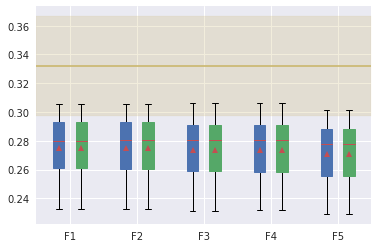

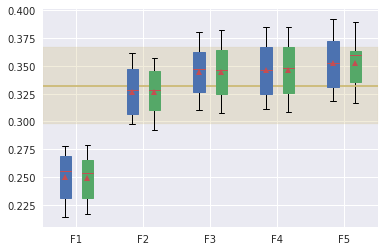

In [281]:
fig, ax = make_base_plot(res, 'Ridge', True, 'mean_squared_error', 'data/')
fig, ax = make_base_plot(res, 'KNeighborsRegressor', True, 'mean_squared_error', 'data/')